In [ ]:
import json
import os
try:
  import sportsipy
except ModuleNotFoundError:
  !pip install sportsipy
  import sportsipy

from sportsipy.nfl.boxscore import Boxscores as nfl_boxscores
from sportsipy.nfl.boxscore import Boxscore as nfl_boxscore
from sportsipy.nfl.roster import Roster as nfl_roster
from sportsipy.nfl.roster import Player as nfl_player
import datetime
from tqdm.notebook import tqdm
import networkx as nx
from itertools import cycle
import pandas as pd
import sys
sys.path.append("/content/drive/MyDrive/Classes/Spring 2022/INFO606: Network Science/Project/src")
from utils import _convert_data_to_gml, _return_graph
%cd /content

class NFLtoNetwork:
  def __init__(self, year: int or str = 2021, week: int = None, level: str = 'Team', regular_season_only: bool = True):
    self.year = year
    self.__week = week
    self.__level = level
    self.__regular_season_only = regular_season_only
    
    # create data
    if isinstance(self.year, int):
      self.__schedule = nflschedules.parse_schedules(self.year)
      self.nodes, self.edges = self._establish_data()
    # multiple years
    else:
      year_splits = sorted(self.year.split('-'))
      assert '-' in self.year and '' not in year_splits, f"Please denote the years in {self.year} as a string split by -. Example: '1998-2000'"
      assert year_splits[0] != year_splits[1], "The years provided must not equal each other"
      years = list(map(int, year_splits))
      year_range = range(years[0], years[1]+1)

      self.nodes = []
      self.edges = []
      for year in year_range:
        self.year = year
        self.__schedule = nflschedules.parse_schedules(self.year)
        node, edge = self._establish_data()
        self.nodes.append(node)
        self.edges.append(edge)
      self.year = list(year_range)

  def _establish_data(self):
    if self.__level == 'Team' or self.__level == 'team':
      nodes, edges = self._prepare_game_data()
    else:
      nodes, edges = self._prepare_player_data()
    return nodes, edges

  def _prepare_game_data(self):
    # find the data specified
    if self.__week is None:
      if self.__regular_season_only:
        data = nfl_boxscores(self.__schedule['regular'][0], self.year, self.__schedule['regular'][-1])
      else:
        data = nfl_boxscores(self.__schedule['regular'][0], self.year, self.__schedule['post'][-1])
    else:
      data = nfl_boxscores(self.__week, self.year)

    games = data.games
    weeks = games.keys()
    nodes = []
    edges = []
    i = 0
    for w in tqdm(weeks):
      week = games[w]
      num_week = int(w.split('-')[0])
      week_name = self.__schedule['name'][num_week]
      for g in week:
        boxscore = g['boxscore']
        away_team = g['away_name']
        home_team = g['home_name']
        away_score = g['away_score']
        home_score = g['home_score']

        edge = {'source': away_team, 'target': home_team, 
                'source_score': away_score, 'target_score': home_score, 
                'week_name': week_name, 'week_num': num_week, 'year': self.year,
                'is_postseason': not self.__regular_season_only}
        edges.append(edge)

        # extract game stats
        game_data = nfl_boxscore(boxscore)

        # extract the location
        home_splits, away_splits = home_team.split(' '), away_team.split(' ')
        home_location, away_location = ' '.join(home_splits[:-1]), ' '.join(away_splits[:-1])
        home_name, away_name = home_splits[-1], away_splits[-1]
        home_node = {'id': home_team, 'label': home_name, 'location': home_location}
        away_node = {'id': away_team, 'label': away_name, 'location': away_location}

        # add nodes to the node list
        if home_node not in nodes:
          nodes.append(home_node)
        if away_node not in nodes:
          nodes.append(away_node)
      i += 1
      
    return nodes, edges

  def _prepare_player_data(self):
    # find the data specified
    if self.__week is None:
      if self.__regular_season_only:
        data = nfl_boxscores(self.__schedule['regular'][0], self.year, self.__schedule['regular'][-1])
      else:
        data = nfl_boxscores(self.__schedule['regular'][0], self.year, self.__schedule['post'][-1])
    else:
      data = nfl_boxscores(self.__week, self.year)
    
    # collect the games and weeks for the given year and week specification
    games = data.games
    weeks = games.keys()
    players = {}
    edges = []
    for w in tqdm(weeks):
      # extract current weeks games
      week = games[w]
      # extract week number
      num_week = int(w.split('-')[0])
      week_name = self.__schedule['name'][num_week]
      for g in week:
        # collect the team's names
        home_team = g['home_name']
        away_team = g['away_name']
        boxscore_data = nfl_boxscore(g['boxscore'])
        #collect the team's players
        home_players = boxscore_data.home_players
        away_players = boxscore_data.away_players
        already_players = list(players.keys())
        for hp in home_players:
          # match each home player to all away players
          hp_name, hp_id = hp.name, hp.player_id
          if hp_id not in already_players:
            extra_label_hp = int(hp_id[-2:])
            if extra_label_hp > 0:
              hp_name += f"({extra_label_hp})"
            # store home plyaer
            hp_player = {'id': hp_id, 'name': hp_name, 'team': home_team}
            players[hp_id] = hp_player
          else:
            hp_player = players[hp_id]
          
          for ap in away_players:
            ap_name, ap_id = ap.name, ap.player_id
            if ap_id not in already_players:
              extra_label_ap = int(ap_id[-2:])
              if extra_label_ap > 0:
                ap_name += f"({extra_label_ap})"
              # store away player
              ap_player = {'id': ap_id, 'name': ap_name, 'team': away_team}
              players[ap_id] = ap_player
            else:
              ap_player = players[ap_id]
            #establish edge and save
            edge = {'source': ap_id, 'target': hp_id, 'source_name': ap_player['name'], 
                    'target_name': hp_player['name'], 'week_name': week_name, 
                    'week_num': num_week, 'year': self.year, 
                    'is_postseason': not self.__regular_season_only}
            edges.append(edge)

    return list(players.values()), edges

SyntaxError: ignored

In [ ]:
nflschedules = NFLSchedules()
nfl = NFLtoNetwork(year = 1980, level='team', regular_season_only=False)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
_convert_data_to_gml('test.json', nfl.nodes, nfl.edges, nfl.year)

In [ ]:
graph = _return_graph('test.json')

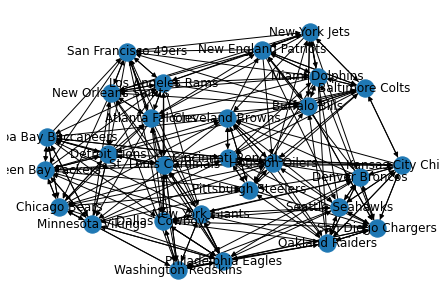

In [ ]:
nx.draw(graph['1980'], with_labels=True)